In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import statsmodels.api as sm
from statsmodels.formula.api import ols
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, RobustScaler
from catboost import CatBoostRegressor
random_state = 123

In [2]:
train = pd.read_csv('data/train_after_outlier.csv', parse_dates=['ofd_date'])
train.head()

,ofd_date,country_code,fc_codes,station_code,OFD,Slam,Earlies_Rec,Rollover,Returns,R_Sideline,Sideline,target
0,2021-02-01,D,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,18645,18982,1177,145,126,356,2,249
1,2021-02-01,D,"F35, F36, F40, F42, F43, F46, F48, F49, F52, F...",D59,16828,16504,333,135,112,256,1,165
2,2021-02-01,D,"F35, F48, F52, F53, F54, F56",D69,12479,12345,196,64,62,136,0,99
3,2021-02-01,D,"F35, F36, F37, F38, F39, F40, F42, F43, F44, F...",D54,18986,18861,446,100,107,248,1,235
4,2021-02-01,D,"F35, F37, F38, F39, F40, F42, F43, F44, F46, F...",D60,16025,15768,383,69,195,15,1,425


In [3]:
train['country_code'].value_counts()

D    3000
A    2922
B    2904
C    2399
Name: country_code, dtype: int64

In [4]:
train['station_code'].value_counts()

D57    150
D52    150
D8     150
D6     150
D3     150
      ... 
D33    120
D39    120
D41    119
D31    119
D47    117
Name: station_code, Length: 80, dtype: int64

In [5]:
# Adding a column that takes the day of the week
train['day_of_week'] = train.apply(lambda x: x['ofd_date'].weekday(), axis=1)
train.rename(columns = {'target':'Diff_val'}, inplace=True)
train.head()

,ofd_date,country_code,fc_codes,station_code,OFD,Slam,Earlies_Rec,Rollover,Returns,R_Sideline,Sideline,Diff_val,day_of_week
0,2021-02-01,D,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,18645,18982,1177,145,126,356,2,249,0
1,2021-02-01,D,"F35, F36, F40, F42, F43, F46, F48, F49, F52, F...",D59,16828,16504,333,135,112,256,1,165,0
2,2021-02-01,D,"F35, F48, F52, F53, F54, F56",D69,12479,12345,196,64,62,136,0,99,0
3,2021-02-01,D,"F35, F36, F37, F38, F39, F40, F42, F43, F44, F...",D54,18986,18861,446,100,107,248,1,235,0
4,2021-02-01,D,"F35, F37, F38, F39, F40, F42, F43, F44, F46, F...",D60,16025,15768,383,69,195,15,1,425,0


In [6]:
# Now let us do our modelling for just 1 station and see how it works before extending it to the rest 
train_station_d57 = train[train['station_code'] == 'D57'].reset_index()
train_station_d57.head()

,index,ofd_date,country_code,fc_codes,station_code,OFD,Slam,Earlies_Rec,Rollover,Returns,R_Sideline,Sideline,Diff_val,day_of_week
0,0,2021-02-01,D,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,18645,18982,1177,145,126,356,2,249,0
1,79,2021-02-02,D,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,17228,19317,473,54,126,2,2,212,1
2,159,2021-02-03,D,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,19897,16589,416,2005,1934,2,1,173,2
3,239,2021-02-04,D,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,19185,18505,302,574,142,1,2,394,3
4,319,2021-02-05,D,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,18115,17977,409,56,122,2,4,407,4


0    22
1    22
2    22
3    21
4    21
5    21
6    21
Name: day_of_week, dtype: int64

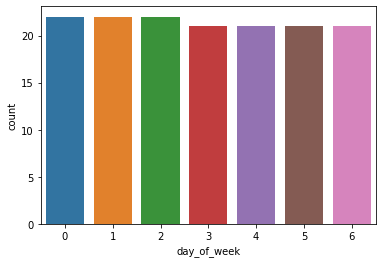

In [7]:
# Number of records for each day of the week for station D57
sns.countplot(x='day_of_week', data = train_station_d57);
train_station_d57['day_of_week'].value_counts()

There aren't any gaps in the time series and hence this is a perfect example for modelling and building a base model

## Anova Analysis 

In [8]:
train_station_d57[train_station_d57['day_of_week'] < 5]['Diff_val'].describe()

count     108.000000
mean      214.083333
std       253.550788
min      -456.000000
25%        58.500000
50%       155.000000
75%       360.250000
max      1918.000000
Name: Diff_val, dtype: float64

In [9]:
train_station_d57[train_station_d57['day_of_week'] > 4]['Diff_val'].describe()

count     42.000000
mean     260.785714
std      241.012654
min      -85.000000
25%       46.250000
50%      175.000000
75%      451.000000
max      878.000000
Name: Diff_val, dtype: float64

In [10]:
anova_table = train_station_d57.copy()
anova_table['is_weekend'] = np.where(anova_table['day_of_week'] < 5, 0, 1)
anova_table.head()

,index,ofd_date,country_code,fc_codes,station_code,OFD,Slam,Earlies_Rec,Rollover,Returns,R_Sideline,Sideline,Diff_val,day_of_week,is_weekend
0,0,2021-02-01,D,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,18645,18982,1177,145,126,356,2,249,0,0
1,79,2021-02-02,D,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,17228,19317,473,54,126,2,2,212,1,0
2,159,2021-02-03,D,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,19897,16589,416,2005,1934,2,1,173,2,0
3,239,2021-02-04,D,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,19185,18505,302,574,142,1,2,394,3,0
4,319,2021-02-05,D,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,18115,17977,409,56,122,2,4,407,4,0


<AxesSubplot:xlabel='is_weekend', ylabel='Diff_val'>

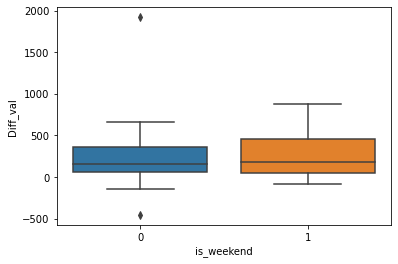

In [11]:
sns.boxplot(y="Diff_val", x="is_weekend", data=anova_table)

In [12]:
mod = ols('Diff_val ~ is_weekend', data=anova_table).fit()
aov_table = sm.stats.anova_lm(mod)
aov_table 

,df,sum_sq,mean_sq,F,PR(>F)
is_weekend,1.0,6.595684e+04,65956.838571,1.054126,0.306234
Residual,148.0,9.260387e+06,62570.184604,NaN,NaN


In [13]:
# Adding whether it is a weekend or not as a column 
train_station_d57['is_weekend'] = np.where(train_station_d57['day_of_week'] < 5, 0, 1)
train_station_d57.head()

,index,ofd_date,country_code,fc_codes,station_code,OFD,Slam,Earlies_Rec,Rollover,Returns,R_Sideline,Sideline,Diff_val,day_of_week,is_weekend
0,0,2021-02-01,D,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,18645,18982,1177,145,126,356,2,249,0,0
1,79,2021-02-02,D,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,17228,19317,473,54,126,2,2,212,1,0
2,159,2021-02-03,D,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,19897,16589,416,2005,1934,2,1,173,2,0
3,239,2021-02-04,D,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,19185,18505,302,574,142,1,2,394,3,0
4,319,2021-02-05,D,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,18115,17977,409,56,122,2,4,407,4,0


## Encoding Categorical Variables

In [14]:
train_station_d57['country_code'].value_counts()

D    150
Name: country_code, dtype: int64

In [15]:
cols_to_encode = ['day_of_week', 'country_code']
train_station_d57[cols_to_encode] = train_station_d57[cols_to_encode].astype('str')
train_station_d57.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   index         150 non-null    int64         
 1   ofd_date      150 non-null    datetime64[ns]
 2   country_code  150 non-null    object        
 3   fc_codes      150 non-null    object        
 4   station_code  150 non-null    object        
 5   OFD           150 non-null    int64         
 6   Slam          150 non-null    int64         
 7   Earlies_Rec   150 non-null    int64         
 8   Rollover      150 non-null    int64         
 9   Returns       150 non-null    int64         
 10  R_Sideline    150 non-null    int64         
 11  Sideline      150 non-null    int64         
 12  Diff_val      150 non-null    int64         
 13  day_of_week   150 non-null    object        
 14  is_weekend    150 non-null    int64         
dtypes: datetime64[ns](1), int64(10), object(

In [16]:
import category_encoders as ce
encoder=ce.OneHotEncoder(cols=cols_to_encode,handle_unknown='ignore',return_df=True,use_cat_names=True)
encoded_df = encoder.fit_transform(train_station_d57)
encoded_df.head()
# train_data = encoded_df.copy()

,index,ofd_date,country_code_D,fc_codes,station_code,OFD,Slam,Earlies_Rec,Rollover,Returns,...,Sideline,Diff_val,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,is_weekend
0,0,2021-02-01,1,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,18645,18982,1177,145,126,...,2,249,1,0,0,0,0,0,0,0
1,79,2021-02-02,1,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,17228,19317,473,54,126,...,2,212,0,1,0,0,0,0,0,0
2,159,2021-02-03,1,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,19897,16589,416,2005,1934,...,1,173,0,0,1,0,0,0,0,0
3,239,2021-02-04,1,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,19185,18505,302,574,142,...,2,394,0,0,0,1,0,0,0,0
4,319,2021-02-05,1,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,18115,17977,409,56,122,...,4,407,0,0,0,0,1,0,0,0


In [17]:
all_cols = encoded_df.columns.tolist()
drop_cols = ['index', 'ofd_date', 'fc_codes', 'station_code', 'Diff_val']
model_cols = list(set(all_cols) - set(drop_cols))
encoded_df[model_cols].head()

,Returns,day_of_week_5,day_of_week_0,is_weekend,day_of_week_2,Earlies_Rec,R_Sideline,country_code_D,Sideline,OFD,day_of_week_6,day_of_week_4,day_of_week_3,Slam,day_of_week_1,Rollover
0,126,0,1,0,0,1177,356,1,2,18645,0,0,0,18982,0,145
1,126,0,0,0,0,473,2,1,2,17228,0,0,0,19317,1,54
2,1934,0,0,0,1,416,2,1,1,19897,0,0,0,16589,0,2005
3,142,0,0,0,0,302,1,1,2,19185,0,0,1,18505,0,574
4,122,0,0,0,0,409,2,1,4,18115,0,1,0,17977,0,56


## Creating the Target Variable

In [18]:
# In order to predict the target variable at time t, we can only use data until t-1
target_column = encoded_df['Diff_val'][1:]
shifted_data = encoded_df.shift(1).dropna().drop(['Diff_val', 'index'], axis=1)
shifted_data['target'] = target_column
shifted_data.head()

,ofd_date,country_code_D,fc_codes,station_code,OFD,Slam,Earlies_Rec,Rollover,Returns,R_Sideline,Sideline,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,is_weekend,target
1,2021-02-01,1.0,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,18645.0,18982.0,1177.0,145.0,126.0,356.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,212
2,2021-02-02,1.0,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,17228.0,19317.0,473.0,54.0,126.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,173
3,2021-02-03,1.0,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,19897.0,16589.0,416.0,2005.0,1934.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,394
4,2021-02-04,1.0,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,19185.0,18505.0,302.0,574.0,142.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,407
5,2021-02-05,1.0,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,18115.0,17977.0,409.0,56.0,122.0,2.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,428


In [19]:
# Splitting the train and test data 
train_data = shifted_data[shifted_data['ofd_date'] < '2021-06-01'].set_index('ofd_date')
test_data = shifted_data[shifted_data['ofd_date'] >= '2021-06-01'].set_index('ofd_date')
train_data.index.freq = 'd'
test_data.index.freq = 'd'

In [20]:
# ## Scaling the Data
# scaler = StandardScaler()
# scale_cols = model_cols.copy()
# scale_cols.append('target')
# train_data[scale_cols] = scaler.fit_transform(train_data[scale_cols])
# test_data[scale_cols] = scaler.transform(test_data[scale_cols])

In [21]:
## Scaling the Data
scaler = RobustScaler()
scale_cols = ['OFD', 'Rollover', 'Returns', 'Slam', 'Earlies_Rec', 'R_Sideline', 'Sideline']
train_data[scale_cols] = scaler.fit_transform(train_data[scale_cols])
test_data[scale_cols] = scaler.transform(test_data[scale_cols])

In [22]:
model_cols

['Returns',
 'day_of_week_5',
 'day_of_week_0',
 'is_weekend',
 'day_of_week_2',
 'Earlies_Rec',
 'R_Sideline',
 'country_code_D',
 'Sideline',
 'OFD',
 'day_of_week_6',
 'day_of_week_4',
 'day_of_week_3',
 'Slam',
 'day_of_week_1',
 'Rollover']

In [51]:
train_data.head(10)

,country_code_D,fc_codes,station_code,OFD,Slam,Earlies_Rec,Rollover,Returns,R_Sideline,Sideline,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,is_weekend,target
ofd_date,,,,,,,,,,,,,,,,,,,
2021-02-01,1.0,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,0.922558,1.092244,2.331015,1.475000,-0.158730,3.522388,0.007005,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,212
2021-02-02,1.0,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,0.467699,1.201533,0.372740,-0.041667,-0.158730,0.000000,0.007005,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,173
2021-02-03,1.0,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,1.324452,0.311557,0.214186,32.475000,28.539683,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,394
2021-02-04,1.0,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,1.095899,0.936628,-0.102921,8.625000,0.095238,-0.009950,0.007005,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,407
2021-02-05,1.0,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,0.752428,0.764375,0.194715,-0.008333,-0.222222,0.000000,0.021016,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,428
2021-02-06,1.0,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,0.371399,0.426719,0.164117,-0.241667,-0.793651,0.019900,1.008757,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,634
2021-02-07,1.0,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,-0.423401,-0.422478,0.336579,0.058333,0.428571,1.144279,2.423818,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,282
2021-02-08,1.0,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,1.224621,1.254384,0.926287,0.625000,-0.444444,3.303483,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-140
2021-02-09,1.0,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,0.849370,1.078868,0.436718,-0.191667,0.873016,0.009950,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,315


In [24]:
# Create and train forecaster with RF 
# ==============================================================================
steps=29
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=random_state),
                lags = 28)
forecaster.fit(y=train_data['target'], exog=train_data[model_cols])
forecaster

# Predictions 
predictions = forecaster.predict(steps=steps, exog=test_data[model_cols])

# Error
error_rmse = mean_squared_error(
                y_true = test_data['target'],
                y_pred = predictions, 
                squared=False)
print(f"Test error (rmse): {error_rmse}")


error_mse = mean_squared_error(
                y_true = test_data['target'],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (rmse): 120.95595872764656
Test error (mse): 14630.343951724139


In [26]:
# Create and train forecaster with Catboost 
# ==============================================================================
steps=29
forecaster = ForecasterAutoreg(
                regressor = CatBoostRegressor(random_state=random_state),
                lags = 28)
forecaster.fit(y=train_data['target'], exog=train_data[model_cols])
forecaster

# Predictions 
predictions = forecaster.predict(steps=steps, exog=test_data[model_cols])

# Error
error_rmse = mean_squared_error(
                y_true = test_data['target'],
                y_pred = predictions, 
                squared=False)
print(f"Test error (rmse): {error_rmse}")


error_mse = mean_squared_error(
                y_true = test_data['target'],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Learning rate set to 0.025524
0:	learn: 258.5217347	total: 1.79ms	remaining: 1.79s
1:	learn: 256.0935173	total: 2.91ms	remaining: 1.45s
2:	learn: 254.0427794	total: 3.86ms	remaining: 1.28s
3:	learn: 251.8500427	total: 4.69ms	remaining: 1.17s
4:	learn: 249.6415232	total: 5.61ms	remaining: 1.11s
5:	learn: 247.1214762	total: 6.28ms	remaining: 1.04s
6:	learn: 244.9257128	total: 7.07ms	remaining: 1s
7:	learn: 242.8902279	total: 8.18ms	remaining: 1.01s
8:	learn: 240.8714091	total: 9.23ms	remaining: 1.02s
9:	learn: 239.0389151	total: 10.1ms	remaining: 1s
10:	learn: 237.1062595	total: 12ms	remaining: 1.08s
11:	learn: 235.0199048	total: 13ms	remaining: 1.07s
12:	learn: 233.0690076	total: 14.4ms	remaining: 1.09s
13:	learn: 231.0356868	total: 15.2ms	remaining: 1.07s
14:	learn: 229.0506578	total: 16.1ms	remaining: 1.05s
15:	learn: 227.1535752	total: 17.1ms	remaining: 1.05s
16:	learn: 225.3652084	total: 18.2ms	remaining: 1.05s
17:	learn: 223.5183942	total: 20.7ms	remaining: 1.13s
18:	learn: 221.849

209:	learn: 79.2800176	total: 360ms	remaining: 1.35s
210:	learn: 78.9370035	total: 362ms	remaining: 1.35s
211:	learn: 78.5928060	total: 363ms	remaining: 1.35s
212:	learn: 78.2103131	total: 364ms	remaining: 1.34s
213:	learn: 77.8608754	total: 365ms	remaining: 1.34s
214:	learn: 77.5341977	total: 367ms	remaining: 1.34s
215:	learn: 77.1822028	total: 369ms	remaining: 1.34s
216:	learn: 76.7696380	total: 371ms	remaining: 1.34s
217:	learn: 76.5106451	total: 372ms	remaining: 1.33s
218:	learn: 76.1456630	total: 374ms	remaining: 1.33s
219:	learn: 75.8506510	total: 376ms	remaining: 1.33s
220:	learn: 75.5828013	total: 378ms	remaining: 1.33s
221:	learn: 75.3240020	total: 383ms	remaining: 1.34s
222:	learn: 75.0532783	total: 385ms	remaining: 1.34s
223:	learn: 74.8162414	total: 386ms	remaining: 1.34s
224:	learn: 74.5178473	total: 388ms	remaining: 1.34s
225:	learn: 74.2069919	total: 390ms	remaining: 1.33s
226:	learn: 73.9152590	total: 397ms	remaining: 1.35s
227:	learn: 73.6594158	total: 399ms	remaining:

406:	learn: 32.6932234	total: 725ms	remaining: 1.06s
407:	learn: 32.4892877	total: 730ms	remaining: 1.06s
408:	learn: 32.2954800	total: 731ms	remaining: 1.06s
409:	learn: 32.0992404	total: 732ms	remaining: 1.05s
410:	learn: 31.8145365	total: 734ms	remaining: 1.05s
411:	learn: 31.7115515	total: 735ms	remaining: 1.05s
412:	learn: 31.6099102	total: 736ms	remaining: 1.05s
413:	learn: 31.4299585	total: 737ms	remaining: 1.04s
414:	learn: 31.2071582	total: 739ms	remaining: 1.04s
415:	learn: 30.9777804	total: 741ms	remaining: 1.04s
416:	learn: 30.8909233	total: 742ms	remaining: 1.04s
417:	learn: 30.7238685	total: 743ms	remaining: 1.03s
418:	learn: 30.5441125	total: 745ms	remaining: 1.03s
419:	learn: 30.3225846	total: 747ms	remaining: 1.03s
420:	learn: 30.1181393	total: 748ms	remaining: 1.03s
421:	learn: 29.9563051	total: 749ms	remaining: 1.03s
422:	learn: 29.8725391	total: 751ms	remaining: 1.02s
423:	learn: 29.6738336	total: 752ms	remaining: 1.02s
424:	learn: 29.4619997	total: 753ms	remaining:

561:	learn: 14.6773274	total: 971ms	remaining: 757ms
562:	learn: 14.6052309	total: 972ms	remaining: 755ms
563:	learn: 14.4974507	total: 974ms	remaining: 753ms
564:	learn: 14.4528914	total: 980ms	remaining: 754ms
565:	learn: 14.3928853	total: 981ms	remaining: 752ms
566:	learn: 14.3660694	total: 982ms	remaining: 750ms
567:	learn: 14.3386020	total: 984ms	remaining: 748ms
568:	learn: 14.2799563	total: 985ms	remaining: 746ms
569:	learn: 14.2533943	total: 987ms	remaining: 744ms
570:	learn: 14.1737262	total: 988ms	remaining: 742ms
571:	learn: 14.0877104	total: 989ms	remaining: 740ms
572:	learn: 14.0617659	total: 993ms	remaining: 740ms
573:	learn: 14.0194029	total: 995ms	remaining: 739ms
574:	learn: 13.9906319	total: 998ms	remaining: 738ms
575:	learn: 13.9638221	total: 1000ms	remaining: 736ms
576:	learn: 13.8635481	total: 1s	remaining: 734ms
577:	learn: 13.7917255	total: 1s	remaining: 732ms
578:	learn: 13.7642139	total: 1s	remaining: 730ms
579:	learn: 13.7394368	total: 1s	remaining: 728ms
580:

790:	learn: 6.2155480	total: 1.35s	remaining: 358ms
791:	learn: 6.1892570	total: 1.36s	remaining: 356ms
792:	learn: 6.1624957	total: 1.36s	remaining: 355ms
793:	learn: 6.1374373	total: 1.36s	remaining: 353ms
794:	learn: 6.1119417	total: 1.36s	remaining: 351ms
795:	learn: 6.0870329	total: 1.36s	remaining: 349ms
796:	learn: 6.0648399	total: 1.36s	remaining: 347ms
797:	learn: 6.0405317	total: 1.37s	remaining: 346ms
798:	learn: 6.0185900	total: 1.37s	remaining: 345ms
799:	learn: 5.9968708	total: 1.37s	remaining: 343ms
800:	learn: 5.9671096	total: 1.37s	remaining: 341ms
801:	learn: 5.9413679	total: 1.37s	remaining: 339ms
802:	learn: 5.9177175	total: 1.38s	remaining: 338ms
803:	learn: 5.8781110	total: 1.38s	remaining: 336ms
804:	learn: 5.8559545	total: 1.38s	remaining: 334ms
805:	learn: 5.8330476	total: 1.38s	remaining: 332ms
806:	learn: 5.7945310	total: 1.38s	remaining: 330ms
807:	learn: 5.7727222	total: 1.38s	remaining: 328ms
808:	learn: 5.7351051	total: 1.38s	remaining: 327ms
809:	learn: 

953:	learn: 3.0157362	total: 1.6s	remaining: 77.4ms
954:	learn: 3.0037974	total: 1.61s	remaining: 75.7ms
955:	learn: 2.9926096	total: 1.61s	remaining: 74ms
956:	learn: 2.9864204	total: 1.61s	remaining: 72.3ms
957:	learn: 2.9746320	total: 1.61s	remaining: 70.6ms
958:	learn: 2.9685588	total: 1.61s	remaining: 69ms
959:	learn: 2.9626167	total: 1.61s	remaining: 67.3ms
960:	learn: 2.9509375	total: 1.62s	remaining: 65.6ms
961:	learn: 2.9451061	total: 1.62s	remaining: 63.9ms
962:	learn: 2.9393998	total: 1.62s	remaining: 62.2ms
963:	learn: 2.9238605	total: 1.62s	remaining: 60.5ms
964:	learn: 2.9143002	total: 1.62s	remaining: 58.8ms
965:	learn: 2.9027981	total: 1.62s	remaining: 57.1ms
966:	learn: 2.8972396	total: 1.63s	remaining: 55.5ms
967:	learn: 2.8917968	total: 1.63s	remaining: 53.8ms
968:	learn: 2.8756308	total: 1.63s	remaining: 52.1ms
969:	learn: 2.8686579	total: 1.63s	remaining: 50.4ms
970:	learn: 2.8633388	total: 1.63s	remaining: 48.7ms
971:	learn: 2.8443971	total: 1.63s	remaining: 47ms


In [43]:
# Create and train forecaster with Adaboost 
# ==============================================================================
steps=29
forecaster = ForecasterAutoreg(
                regressor = AdaBoostRegressor(random_state=random_state),
                lags = 28)
forecaster.fit(y=train_data['target'], exog=train_data[model_cols])
forecaster

# Predictions 
predictions = forecaster.predict(steps=steps, exog=test_data[model_cols])

# Error
error_rmse = mean_squared_error(
                y_true = test_data['target'],
                y_pred = predictions, 
                squared=False)
print(f"Test error (rmse): {error_rmse}")


error_mse = mean_squared_error(
                y_true = test_data['target'],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (rmse): 115.37810496179249
Test error (mse): 13312.107104574403


In [50]:
train_data

,country_code_D,fc_codes,station_code,OFD,Slam,Earlies_Rec,Rollover,Returns,R_Sideline,Sideline,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,is_weekend,target
ofd_date,,,,,,,,,,,,,,,,,,,
2021-02-01,1.0,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,0.922558,1.092244,2.331015,1.475000,-0.158730,3.522388,0.007005,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,212
2021-02-02,1.0,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,0.467699,1.201533,0.372740,-0.041667,-0.158730,0.000000,0.007005,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,173
2021-02-03,1.0,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,1.324452,0.311557,0.214186,32.475000,28.539683,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,394
2021-02-04,1.0,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,1.095899,0.936628,-0.102921,8.625000,0.095238,-0.009950,0.007005,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,407
2021-02-05,1.0,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,0.752428,0.764375,0.194715,-0.008333,-0.222222,0.000000,0.021016,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-27,1.0,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,-0.247492,-0.253487,-0.709318,0.225000,-0.841270,-0.009950,-0.007005,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,86
2021-05-28,1.0,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,-0.297568,-0.249898,-0.442281,-0.208333,-0.682540,-0.019900,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-85
2021-05-29,1.0,"F35, F40, F42, F43, F46, F48, F52, F53, F55, F56",D57,-0.770404,-0.672376,-0.511822,0.125000,-0.365079,-0.009950,0.777583,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,10


In [49]:
forecaster = ForecasterAutoreg(
                regressor = AdaBoostRegressor(random_state=random_state),
                lags = 28)
forecaster.create_train_X_y(y=train_data['target'], exog=train_data[model_cols])[0]

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,R_Sideline,country_code_D,Sideline,OFD,day_of_week_6,day_of_week_4,day_of_week_3,Slam,day_of_week_1,Rollover
ofd_date,,,,,,,,,,,,,,,,,,,,,
2021-03-01,280.0,779.0,359.0,428.0,476.0,297.0,283.0,463.0,655.0,528.0,...,2.457711,1.0,0.000000,1.135703,0.0,0.0,0.0,1.280483,0.0,0.708333
2021-03-02,358.0,280.0,779.0,359.0,428.0,476.0,297.0,283.0,463.0,655.0,...,0.000000,1.0,0.007005,1.047749,0.0,0.0,0.0,1.022103,1.0,1.075000
2021-03-03,553.0,358.0,280.0,779.0,359.0,428.0,476.0,297.0,283.0,463.0,...,0.000000,1.0,0.014011,0.762058,0.0,0.0,0.0,0.789821,0.0,0.691667
2021-03-04,659.0,553.0,358.0,280.0,779.0,359.0,428.0,476.0,297.0,283.0,...,0.009950,1.0,0.000000,1.100393,0.0,0.0,1.0,1.061904,0.0,0.575000
2021-03-05,467.0,659.0,553.0,358.0,280.0,779.0,359.0,428.0,476.0,297.0,...,-0.009950,1.0,0.007005,0.892384,0.0,1.0,0.0,0.997309,0.0,0.008333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-27,112.0,-1.0,63.0,86.0,135.0,45.0,119.0,93.0,86.0,28.0,...,-0.009950,1.0,-0.007005,-0.247492,0.0,0.0,1.0,-0.253487,0.0,0.225000
2021-05-28,86.0,112.0,-1.0,63.0,86.0,135.0,45.0,119.0,93.0,86.0,...,-0.019900,1.0,0.000000,-0.297568,0.0,1.0,0.0,-0.249898,0.0,-0.208333
2021-05-29,-85.0,86.0,112.0,-1.0,63.0,86.0,135.0,45.0,119.0,93.0,...,-0.009950,1.0,0.777583,-0.770404,0.0,0.0,0.0,-0.672376,0.0,0.125000
